In [759]:
from s04utils.modules.load import timestamps

from bokeh.plotting import figure, show, output_notebook, curdoc
from matplotlib_inline.backend_inline import set_matplotlib_formats

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from sfHMM import sfHMM1
from sfHMM.gmm import GMMs

from pybaselines import Baseline

In [760]:
# Set quality for plt plots
set_matplotlib_formats('retina')

# Set output style for bokeh plots
#curdoc().theme = 'dark_minimal'
output_notebook()

Loading BokehJS ...

In [761]:
SOURCE_PATH = '/Users/kappel/Messungen/Setup04/JaKa/post_hack/23_08_25/77K-33nM-eGFP-vitrified/05uW/timestamps/tt_eGFP_33nm_NaP_100mM_ph7dot5_Treh7dot5_05uW_77K_circpol_015.h5'

In [762]:
# Load timestamps from file
ts = timestamps.load_from_path(path=SOURCE_PATH)

In [763]:
# Set bin time in seconds
bin_time = 0.01 # 10ms

# Create binned timetrace
timetrace = ts.get_timetrace_data(bin_width=bin_time)

# Get the binned timetrace data for each individual detector
detector_0 = timetrace['detector0'][0]
detector_1 = timetrace['detector1'][0]

# Get the binned timetrace data for the sum of both detectors
detector_sum = timetrace['detector0'][0] + timetrace['detector1'][0]

# Create a pandas dataframe
df = pd.DataFrame({'detector0': detector_0, 'detector1': detector_1, 'detector_sum': detector_sum})

55.773811935
11154762387
5577.381193499999


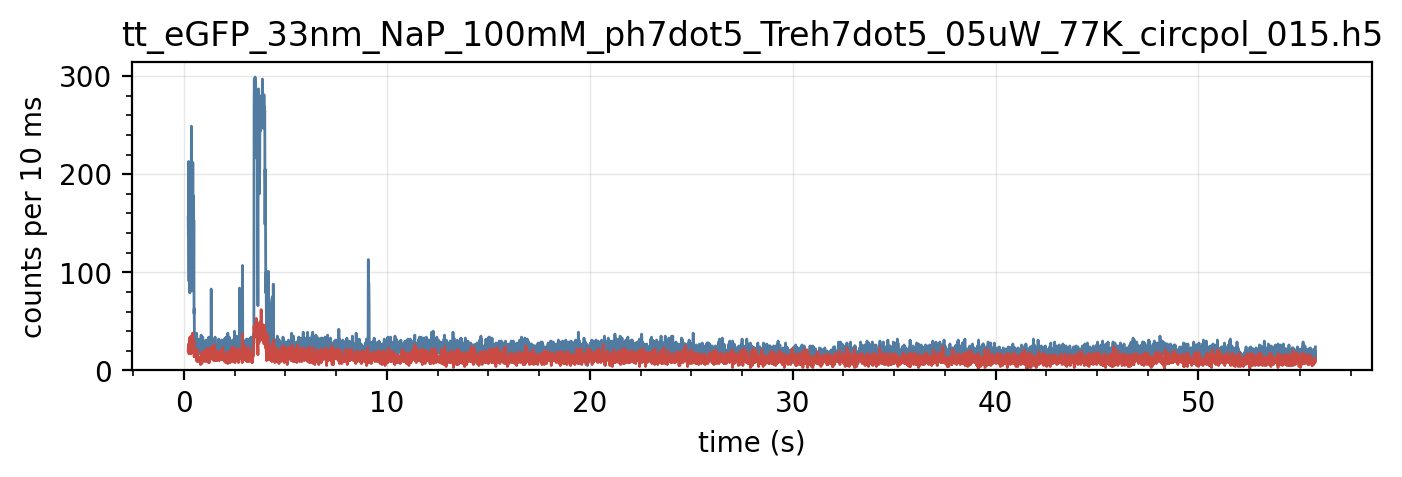

In [777]:
ts.preview()

In [764]:
# create the same plot in bokeh
p = figure(width=800, height=300)
p.line(x=df.index, y=df['detector_sum'], line_width=1, color='blue', legend_label='detector_sum')
p.line(x=df.index, y=df['detector0'], line_width=1, color='red', legend_label='detector0')
p.line(x=df.index, y=df['detector1'], line_width=1, color='green', legend_label='detector1')
p.legend.location = 'top_right'
show(p)

4


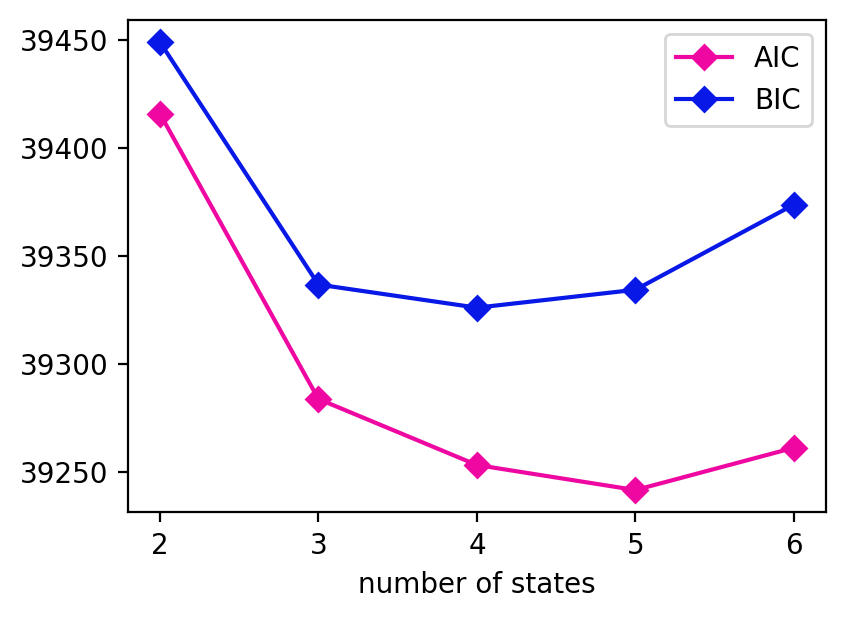

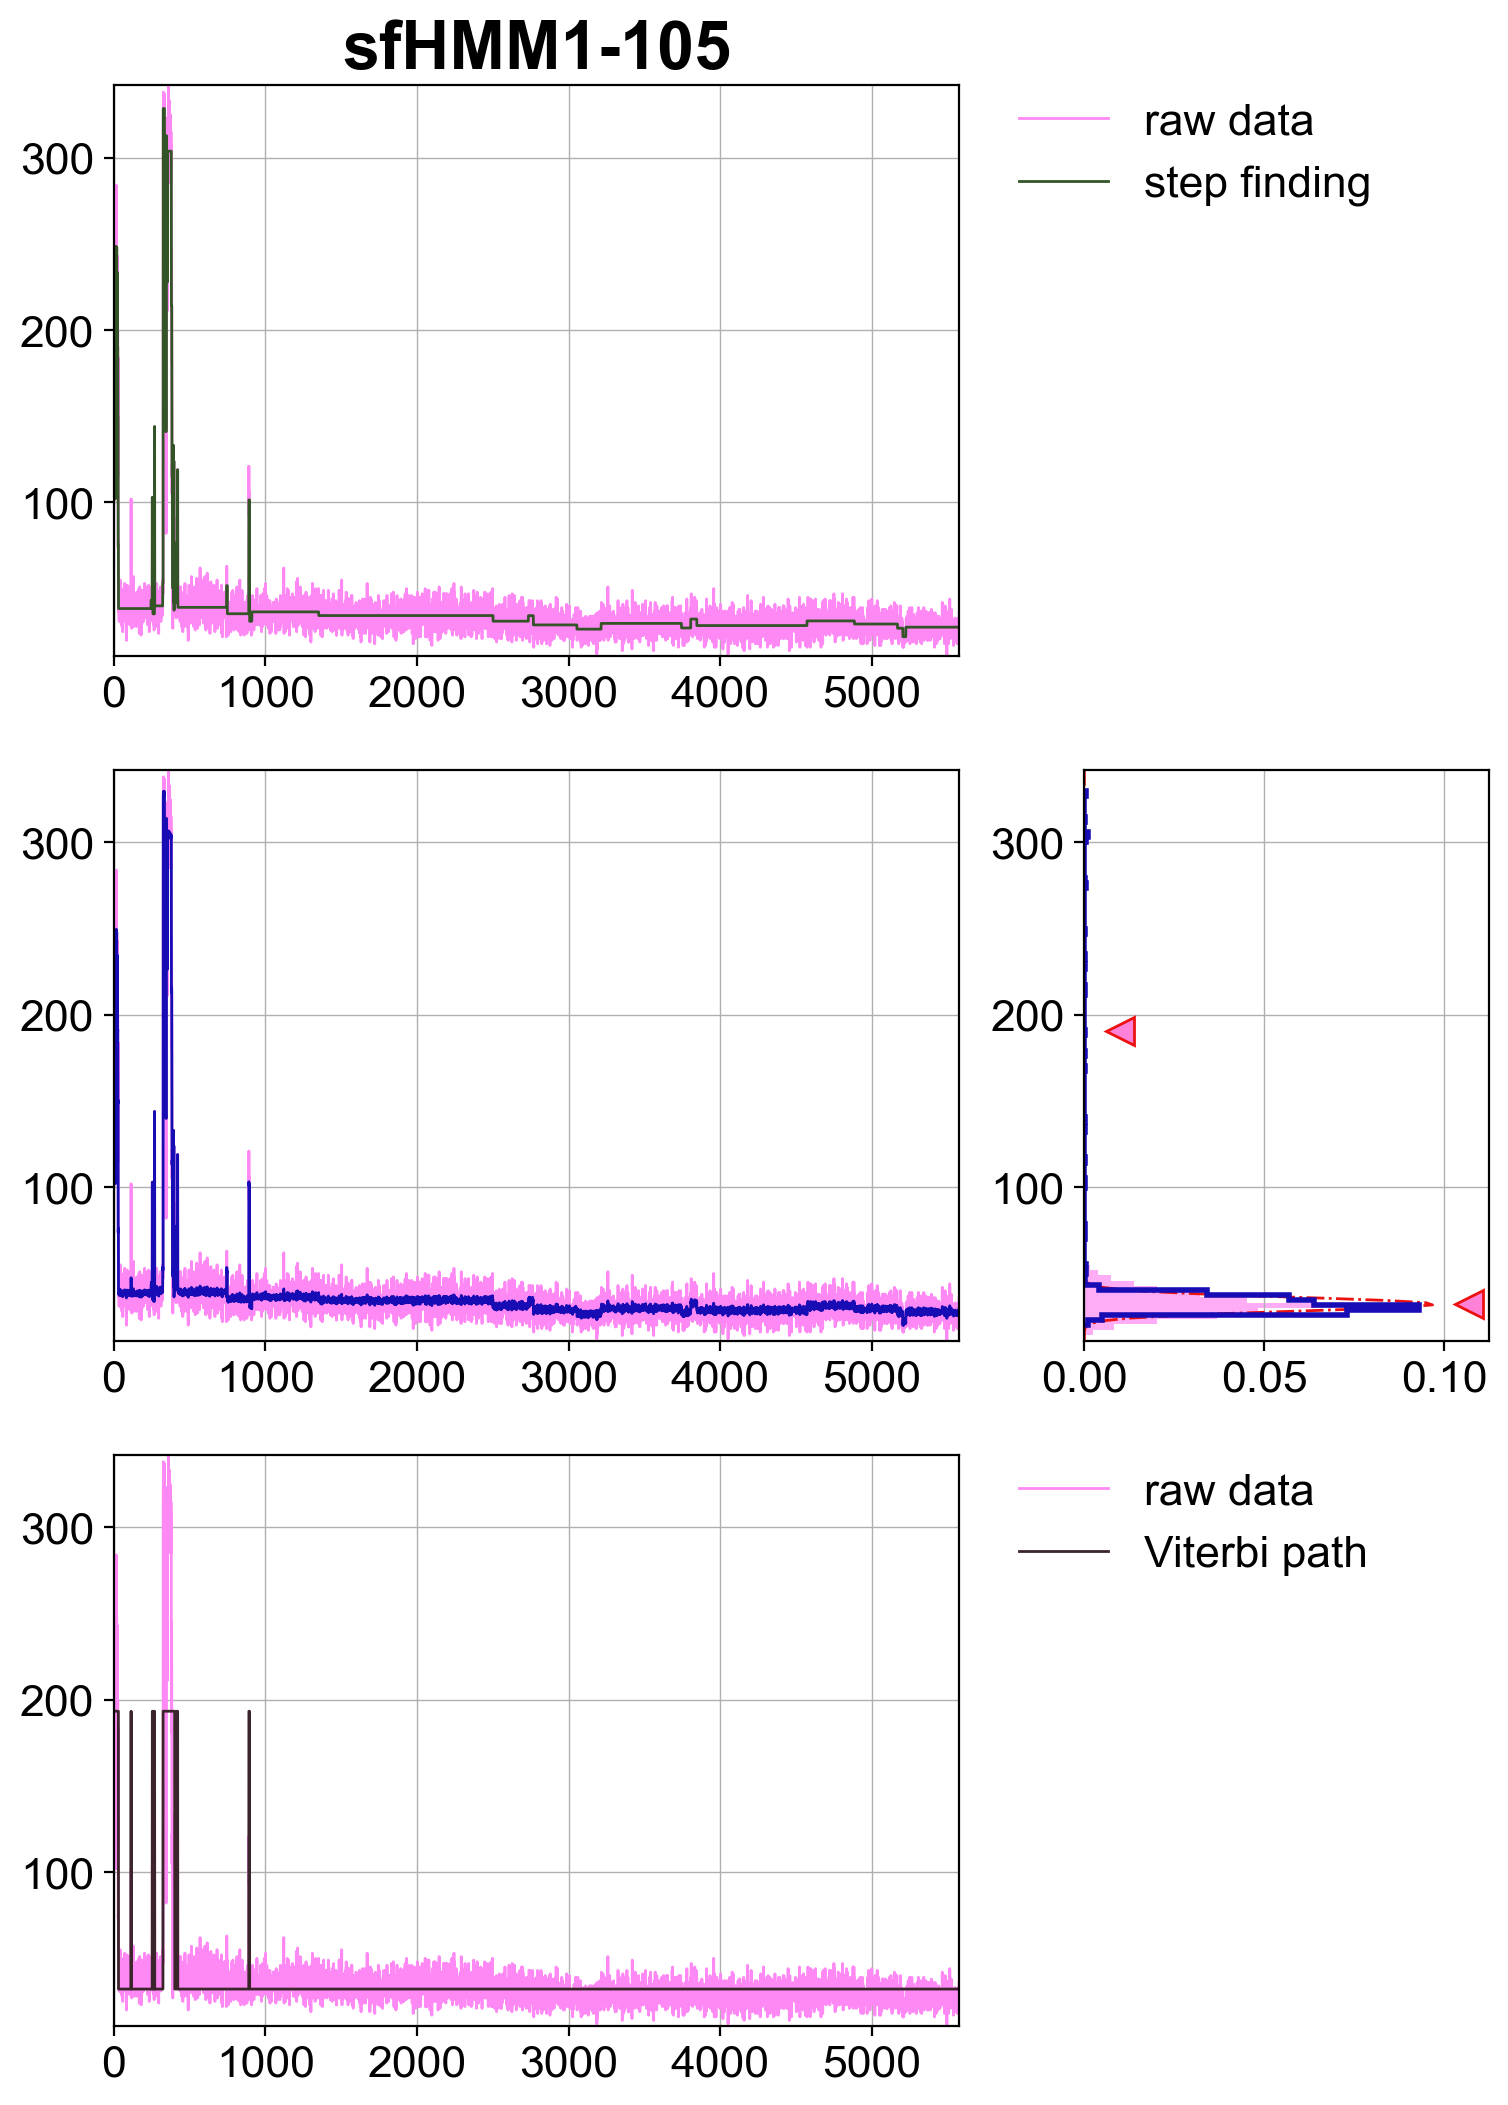

In [765]:
gmms = GMMs(df['detector_sum'], krange=(2, 6))
gmms.fit()
gmms.show_aic_bic()
#gmms.plot_all()


gmms_opt_n = gmms.get_optimal(criterion="bic").n_components

print(gmms_opt_n)

sfp_two_states = sfHMM1(df['detector_sum'], krange=(2, 2), model='p').run_all()

In [766]:
# create the same plot in bokeh
p = figure(width=800, height=300)
#p.line(x=df.index, y=sfp_two_states.data_raw, line_width=1, color='lightgrey', legend_label='detector_sum')
p.line(x=df.index, y=sfp_two_states.data_fil, line_width=1, color='darkgrey', legend_label='detector0', alpha=0.5)
p.line(x=df.index, y=sfp_two_states.viterbi, line_width=2, color='red', legend_label='viterbi')
p.legend.location = 'top_right'
p.title.text = f"sfHMM1 with 2 states (forced)"
show(p)

In [767]:
# create three lists for the three states
state_0 = []
state_1 = []


# initialize variables to keep track of the start and end indices of each interval
start_idx = 0
prev_state = sfp_two_states.states[0]

# iterate over the state values and extract the length of each interval
for i, state in enumerate(sfp_two_states.states):
    if state != prev_state:
        # the state has changed, so we've reached the end of an interval
        end_idx = i - 1
        interval_length = end_idx - start_idx + 1
        if prev_state == 0:
            state_0.append(interval_length)
        elif prev_state == 1:
            state_1.append(interval_length)
        start_idx = i
        prev_state = state

# handle the last interval
end_idx = len(sfp_two_states.states) - 1
interval_length = end_idx - start_idx + 1
if prev_state == 0:
    state_0.append(interval_length)
elif prev_state == 1:
    state_1.append(interval_length)

# print the lengths of the intervals for each state
print("State 0 intervals:", state_0)
print("State 1 intervals:", state_1)

# delete largest interval in state 0
state_0.remove(np.max(state_0))

# get max value from each state
max_state_0 = np.max(state_0)
max_state_1 = np.max(state_1)

# get total max value
max_interval = np.max([max_state_0, max_state_1])

State 0 intervals: [83, 139, 12, 55, 13, 469, 4681]
State 1 intervals: [31, 1, 3, 1, 77, 7, 5]


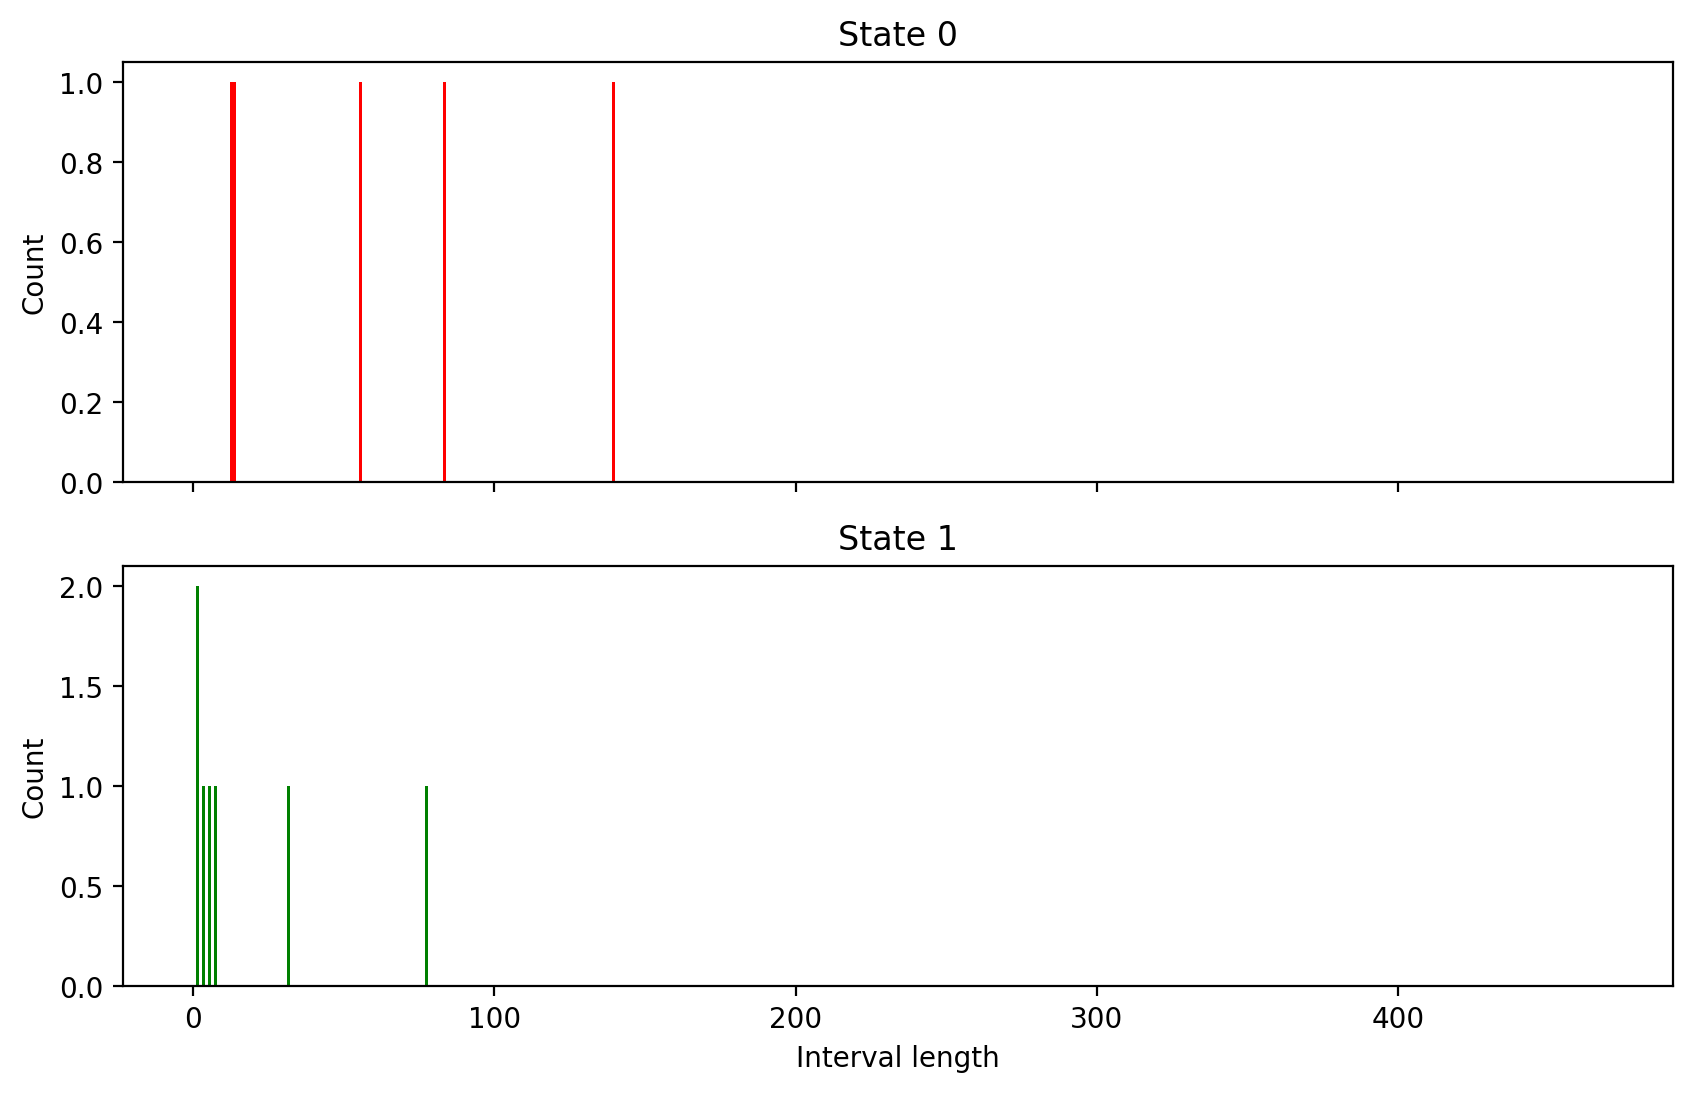

In [768]:
# create a figure with three subplots
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# create a histogram for each state
ax0.hist(state_0, bins=range(0, max_interval, 1), color='red')
ax1.hist(state_1, bins=range(0, max_interval, 1), color='green')

# set the title for each subplot
ax0.set_title('State 0')
ax1.set_title('State 1')

# set the x-axis label for the bottom subplot
ax1.set_xlabel('Interval length')

# set the y-axis label for each subplot
ax0.set_ylabel('Count')
ax1.set_ylabel('Count')

plt.show()

{32.17007513718566: 5452, 193.3091626157824: 125}
High state: 193.3091626157824
Low state: 32.17007513718566
Last value change: 895
Cut offset: 447
5577


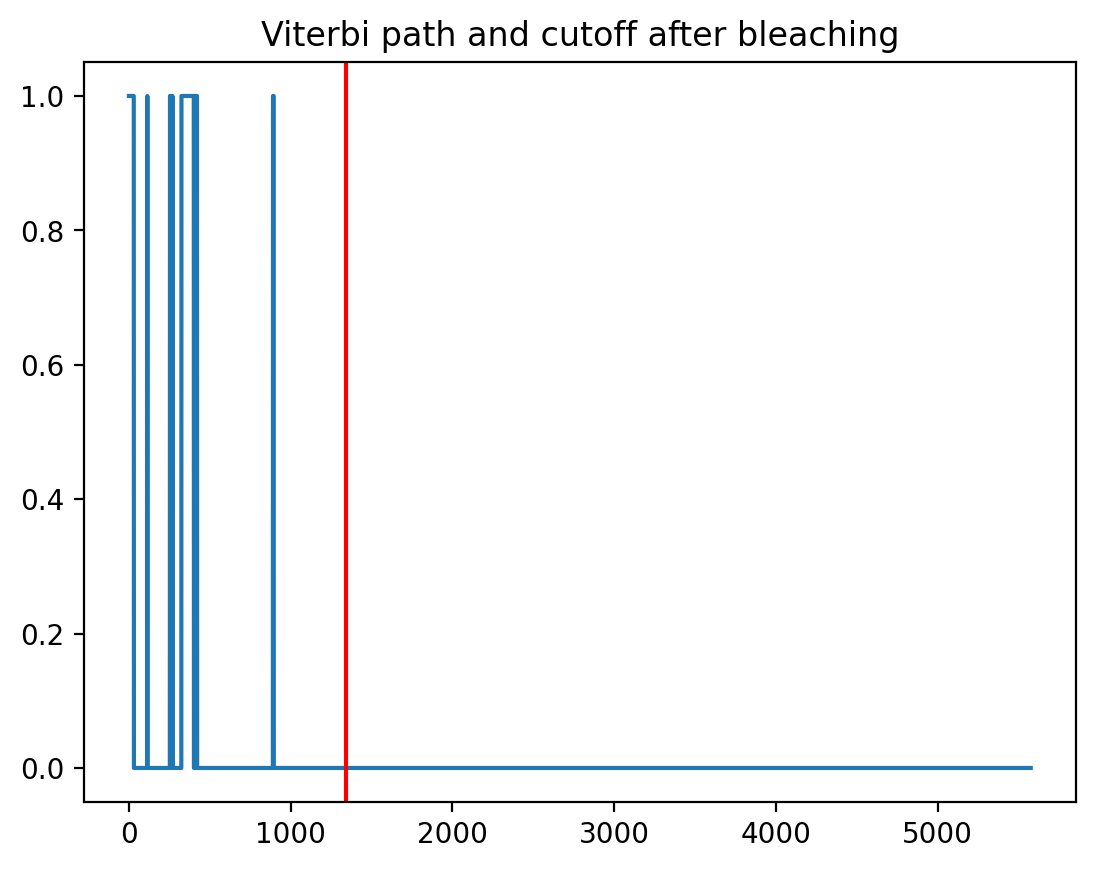

In [769]:
# get the viterbi path
steps_viterbi = sfp_two_states.viterbi

# get unique values
unique, counts = np.unique(steps_viterbi, return_counts=True)
print(dict(zip(unique, counts)))

high_state = unique[1]
low_state = unique[0]

print('High state: ' + str(high_state))
print('Low state: '+ str(low_state))

steps = steps_viterbi.copy()

# assign 0 and 1 to the states in viterbi path
steps[steps_viterbi == high_state] = 1
steps[steps_viterbi == low_state] = 0

# find indices where the state changes
value_change = np.where(np.diff(steps))[0]

last_value_change = value_change[-1]

# set cutoff value
CUT_OFFSET = int(last_value_change / 2)
print('Last value change: ' + str(last_value_change))
print('Cut offset: ' + str(CUT_OFFSET))
print(len(steps))

# correct CUT_OFFSET if it is too large
if (last_value_change + CUT_OFFSET) > len(steps):
    print('Offset out of bounds, correcting offset')
    CUT_OFFSET = steps[-1] + 1

# plot the last value chnage as a vertical line
plt.plot(steps)
plt.axvline(last_value_change+CUT_OFFSET, color='red')
plt.title('Viterbi path and cutoff after bleaching')
plt.show()

In [770]:
cutoff_index = int(value_change[-1]+CUT_OFFSET)
print(cutoff_index)

1342


3


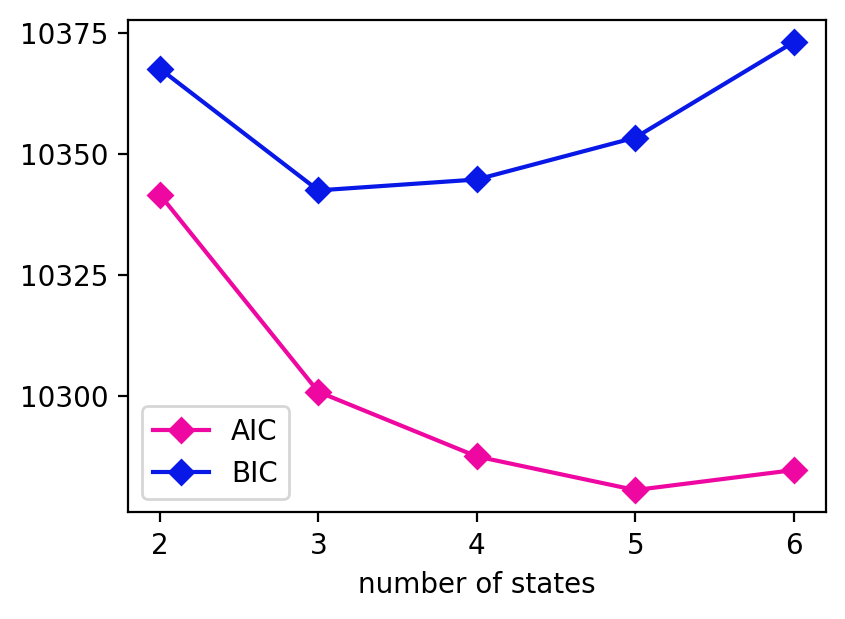

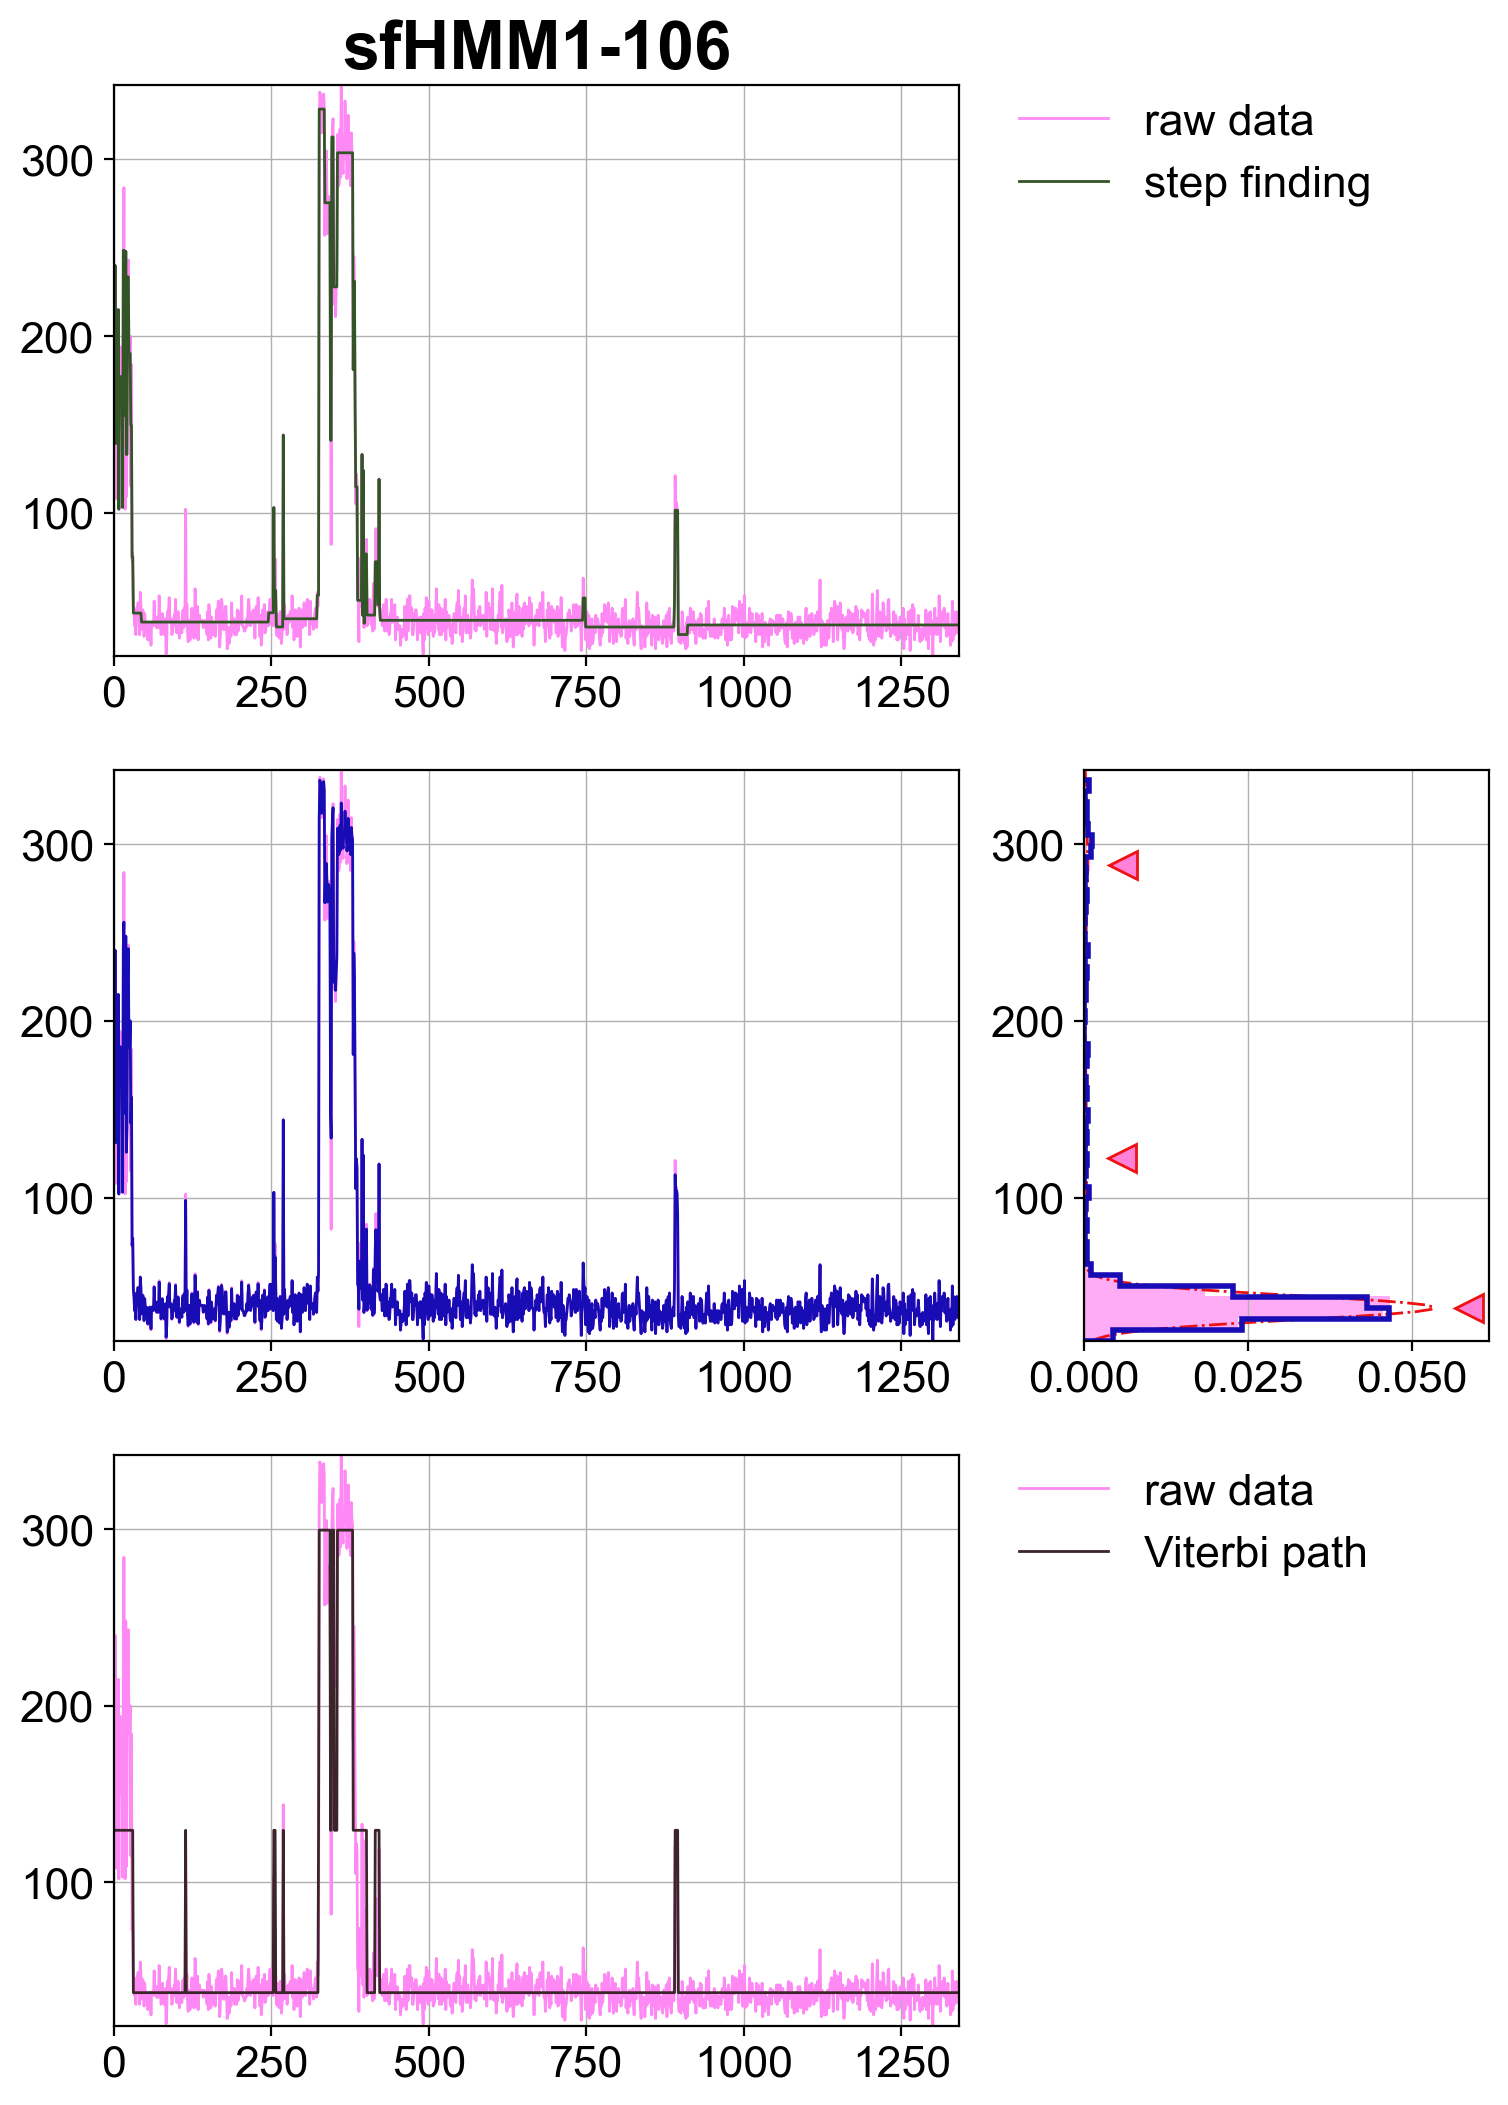

In [771]:
# cut the data at the last value change
df_cut = df.iloc[:cutoff_index]

gmms = GMMs(df_cut['detector_sum'], krange=(2, 6))
gmms.fit()
gmms.show_aic_bic()
#gmms.plot_all()


gmms_opt_n = gmms.get_optimal(criterion="bic").n_components

print(gmms_opt_n)

sfp = sfHMM1(df_cut['detector_sum'], krange=(2, gmms_opt_n), model='p').run_all()

sf.sg0 =
 7.375641025641027
sfp.n_components =
 3
sfp.means_ =
 [[ 37.61744348]
 [129.52028325]
 [299.40197222]]
sfp.states =
 [1 1 1 ... 0 0 0]


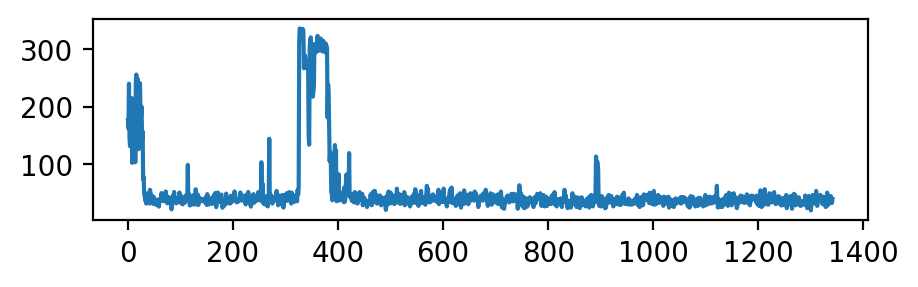

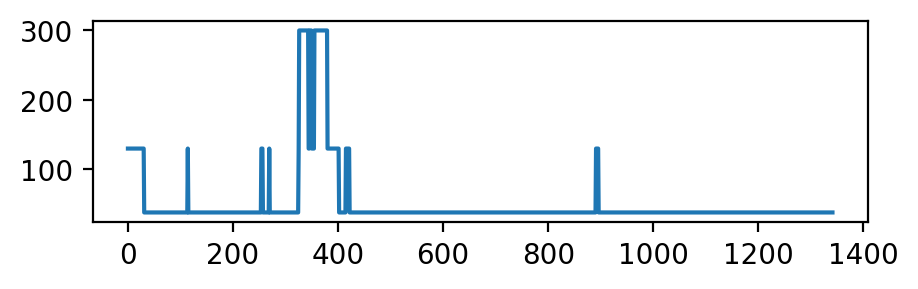

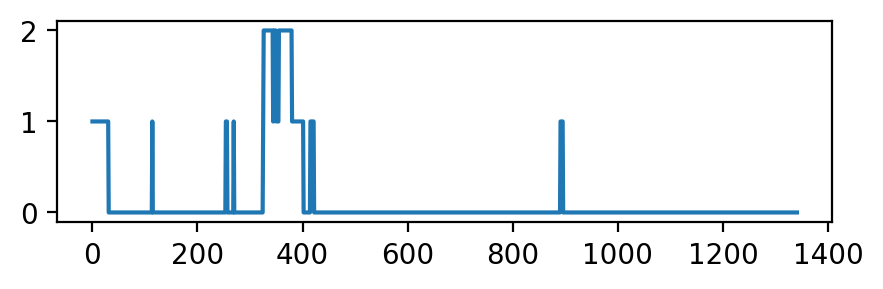

In [772]:
print("sf.sg0 =\n", sfp.sg0)
print("sfp.n_components =\n", sfp.n_components)
print("sfp.means_ =\n", sfp.means_)
print("sfp.states =\n", sfp.states)
plt.figure(figsize=(5, 1.3))
plt.plot(sfp.data_fil)
plt.show()
plt.figure(figsize=(5, 1.3))
plt.plot(sfp.viterbi)
plt.show()
plt.figure(figsize=(5, 1.3))
plt.plot(sfp.states)
plt.show()

In [773]:
# create the same plot in bokeh
p = figure(width=800, height=300)
#p.line(x=df_cut.index, y=sfp.data_raw, line_width=1, color='lightgrey', legend_label='data_raw')
p.line(x=df.index, y=sfp.data_fil, line_width=1, color='darkgrey', legend_label='detector0', alpha=0.5)
p.line(x=df_cut.index, y=sfp.viterbi, line_width=2, color='red', legend_label='viterbi')
p.legend.location = 'top_right'
p.title.text = f"sfHMM1 with {gmms_opt_n} states (calculated optimum)"
show(p)

In [774]:
print(sfp.states)
print(len(sfp.states))

[1 1 1 ... 0 0 0]
1342


In [775]:
# create three lists for the three states
state_0 = []
state_1 = []
state_2 = []

# initialize variables to keep track of the start and end indices of each interval
start_idx = 0
prev_state = sfp.states[0]

# iterate over the state values and extract the length of each interval
for i, state in enumerate(sfp.states):
    if state != prev_state:
        # the state has changed, so we've reached the end of an interval
        end_idx = i - 1
        interval_length = end_idx - start_idx + 1
        if prev_state == 0:
            state_0.append(interval_length)
        elif prev_state == 1:
            state_1.append(interval_length)
        elif prev_state == 2:
            state_2.append(interval_length)
        start_idx = i
        prev_state = state

# handle the last interval
end_idx = len(sfp.states) - 1
interval_length = end_idx - start_idx + 1
if prev_state == 0:
    state_0.append(interval_length)
elif prev_state == 1:
    state_1.append(interval_length)
elif prev_state == 2:
    state_2.append(interval_length)

# print the lengths of the intervals for each state
print("State 0 intervals:", state_0)
print("State 1 intervals:", state_1)
print("State 2 intervals:", state_2)

# get max value from each state
max_state_0 = np.max(state_0)
max_state_1 = np.max(state_1)
max_state_2 = np.max(state_2)

# get total max value
max_interval = np.max([max_state_0, max_state_1, max_state_2])

# multiply each time interval by the bin time to get the time in seconds

State 0 intervals: [83, 139, 12, 55, 13, 469, 446]
State 1 intervals: [31, 1, 3, 1, 1, 2, 5, 22, 7, 5]
State 2 intervals: [18, 4, 25]


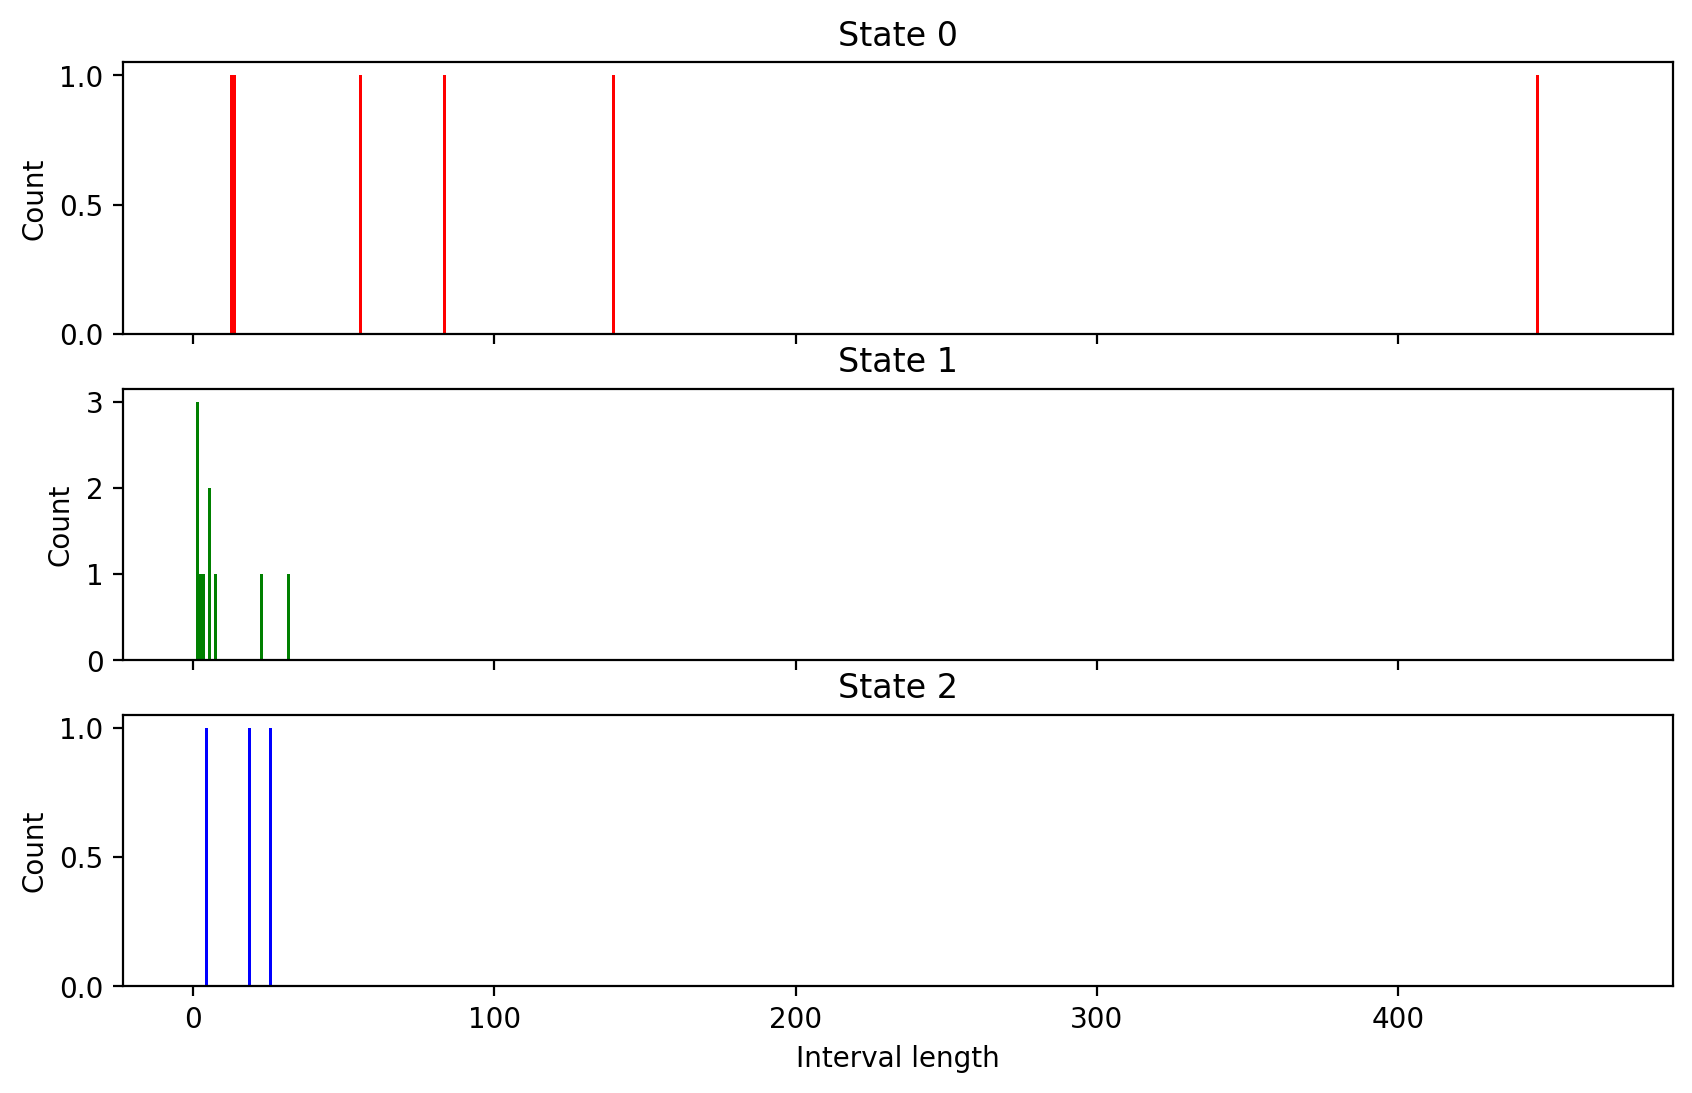

In [776]:
# create a figure with three subplots
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

# create a histogram for each state
ax0.hist(state_0, bins=range(0, max_interval, 1), color='red')
ax1.hist(state_1, bins=range(0, max_interval, 1), color='green')
ax2.hist(state_2, bins=range(0, max_interval, 1), color='blue')

# set the title for each subplot
ax0.set_title('State 0')
ax1.set_title('State 1')
ax2.set_title('State 2')

# set the x-axis label for the bottom subplot
ax2.set_xlabel('Interval length')

# set the y-axis label for each subplot
ax0.set_ylabel('Count')
ax1.set_ylabel('Count')
ax2.set_ylabel('Count')

plt.show()
